# 0. Set up
## 0.1 If if needed, clone Demeter with git

In [1]:
!git clone --branch feature/002-rotation https://github.com/antonfrancois/Demeter_metamorphosis.git

Cloning into 'Demeter_metamorphosis'...
remote: Enumerating objects: 5758, done.
remote: Counting objects: 100% (317/317), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 5758 (delta 197), reused 237 (delta 143), pack-reused 5441 (from 1)
Receiving objects: 100% (5758/5758), 622.27 MiB | 16.75 MiB/s, done.
Resolving deltas: 100% (3765/3765), done.
Updating files: 100% (176/176), done.


In [ ]:
!git pull origin feature/002-rotation

From https://github.com/antonfrancois/Demeter_metamorphosis
 * branch            feature/002-rotation -> FETCH_HEAD
Already up to date.


In [ ]:
!git status

fatal: not a git repository (or any of the parent directories): .git


and install the package

In [1]:
import subprocess
import sys, os

cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/

!pip install pynrrd
!pip install -U ipywidgets
print("\nInstalation of demeter from pip")
!pip install -e .
# !pip install -e .

repo_path = os.path.abspath('.')
# repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)


/content/Demeter_metamorphosis
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1

Instalation of demeter from pip
Obtaining file:///content/Demeter_metamorphosis
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for demeter_metamorphosis (pyproject.toml) ... done
  Created wheel for demeter_metamorphosis: filename=demeter_metamorphosis-0.2.11

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 0.2 After jupyter restart, run :

In [2]:


import sys
import os


# Remplace par le chemin relatif où se trouve le package 'demeter'
# Exemple : si ton notebook est dans le dossier root du repo, et demeter est un sous-dossier
import subprocess
cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/

# repo_path = os.path.abspath('.')
repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)



/content/Demeter_metamorphosis
['/content/Demeter_metamorphosis/', '/content/examples/', '/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/content/Demeter_metamorphosis/src', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython']


# 1. code utile

## imports

In [3]:
import demeter.utils.torchbox as tb
from demeter.constants import *
import demeter.metamorphosis as mt
import demeter.utils.reproducing_kernels as rk
import demeter.utils.rigid_exploration as rg
from matplotlib.colors import ListedColormap
import sys
import os
cmap_segs = ListedColormap(
    [[0,0,0,0],
     'tab:blue',
     'tab:blue',
     'tab:orange'
     ])
DLT_KW_SEG= dict(alpha=.5,
                 cmap=cmap_segs,
                 interpolation='nearest'
                 )

# Add the directory containing brats_utils to the Python path
brats_utils_path = os.path.join(os.path.abspath('.'), 'examples/') # Assuming brats_utils is in a 'src' subdirectory
print(brats_utils_path)

if brats_utils_path not in sys.path:
    sys.path.insert(0, brats_utils_path)

import brats_utils as bu

%load_ext autoreload
%autoreload 2
import demeter.metamorphosis.rotate as mtrt
import demeter.utils.axes3dsliders_plt as a3s
from scipy.spatial.transform import Rotation as R

# from ipywidgets import ToggleButton, ToggleButtonStyle
from ipywidgets.widgets.widget_bool import ToggleButtonStyle


# term_width = os.get_terminal_size().columns
term_width = 30


def prepare_momenta(image_shape,
                    image : bool = True,
                    rotation : bool = True,
                    translation : bool = True,
                    rot_prior = None,
                    trans_prior= None,
                    device = "cuda:0",
                    requires_grad = True):
    dim = 2 if len(image_shape) == 4 else 3
    if rot_prior is None:
        rot_prior = torch.zeros((dim,))
    if trans_prior is None:
        trans_prior = [0] * dim
    momenta = {}
    kwargs = {
        "dtype":torch.float32,
        "device":device
    }
    if image:
        momenta["momentum_I"]= torch.zeros(S.shape,**kwargs)
    if rotation:
        if len(rot_prior.shape)==2:
            momenta["momentum_R"] = torch.tensor(rot_prior,**kwargs)
        elif len(rot_prior.shape)==1:
            r1, r2, r3 = rot_prior
            momenta["momentum_R"] = torch.tensor(
            [[0,-r1, -r2 ],
                     [r1, 0, -r3],
                     [r2, r3, 0]],
                    dtype=torch.float32, device='cuda:0')
        else:
            raise ValueError("Rotation prior must be 2 or 1 dimensional")
    if translation:
        momenta["momentum_T"]= torch.tensor(trans_prior,
                                            **kwargs)

    for keys in momenta.keys():
        momenta[keys].requires_grad=requires_grad

    return momenta

def random_affine_def():
    rdm_angle = torch.randn((3,))/4
    rdm_translation = torch.randn((3,))/15

    args_aff = torch.cat(
        [
            rdm_angle,
            rdm_translation,
            torch.ones_like(rdm_angle)
        ], dim = 0
    )
    print(args_aff)

    # args_aff = torch.tensor(
    #         [.6,-.3, 0, # angle
    #         .1,.02,0,   # translation
    #         1,1,1] # scaling
    # )
    aff_mat = tb.create_affine_mat_3d(args_aff)
    print(aff_mat)
    aff_grid = tb.affine_to_grid_3d(aff_mat, img_1.shape[2:])
    return aff_grid, aff_mat


def pixel_to_2square_landmark(landmarks, image_size):
    if len(image_size) > 3:
        image_size = image_size[2:]
    landmarks = landmarks.clone().float()
    for i in range(landmarks.shape[1]):
        landmarks[:,i] *= 2/ (image_size[i] )
    return landmarks - 1

def test_pixel_to_2square_landmark():
    landmarks = torch.tensor(
        [[0,0,0],[240,240,155],[240//2, 240//2, 155//2]]
    )
    img_shape = (1, 1, 240, 240, 155)
    expected_result = torch.tensor([[-1.0000, -1.0000, -1.0000],
        [ 1.0000,  1.0000,  1.0000],
        [ 0.0000,  0.0000, -0.0065]])
    actual_result = pixel_to_2square_landmark(landmarks, img_shape)
    print('landmarks',landmarks)
    print("landmarks processed",pixel_to_2square_landmark(landmarks,img_shape))
    assert expected_result == actual_result

def apply_aff_to_landmarks(landmarks, grid):
    """
    Transport landmarks by a deformation grid.
    """
    new_land = torch.zeros_like(landmarks)
    for i, l in enumerate(landmarks):
        new_land[i]  = grid[:, int(l[2]), int(l[1]), int(l[0])]            # Bad orient

    return new_land

def inverse_affine(affine):
    """
    Compute the inverse of the affine transformation.
    """
    rot = affine[:3, :3]
    trans = affine[:3, 3][None]
    inv_rot = rot.T
    inv_trans = - trans.T

    new_aff = torch.cat([inv_rot, inv_trans], dim=1)
    return  torch.cat([new_aff, affine[-1][None]], dim=0)

def plot_metamorphosis_slices(mr):
    """
    Plots slices of the metamorphosis images at each time step and compares them
    to the target image.

    Args:
        mr: An object representing the metamorphosis process, expected to have
            an attribute mr.mp.image_stock (tensor of shape [T, 1, D, H, W])
            and mr.target (tensor of shape [1, D, H, W]).
    """

    # mr.to_device('cpu')
    image_stock = mr.mp.image_stock.cpu()  # Remove channel dim and move to numpy
    T, _, D, H, W = image_stock.shape

    # apply rotation to target
    rot_def =  mr.mp.get_rotator_translator()
    print("rot_def device:", rot_def.device)

    rotated_img_stock = tb.imgDeform(mr.mp.image_stock.cpu(),rot_def.cpu(),dx_convention='2square')

    # Choose a central slice for plotting
    slice_index = W // 2
    target_tensor = mr.target[..., slice_index].to("cpu") # Get the slice and add batch/channel dims


    fig, axes = plt.subplots(T, 2, figsize=(10, T * 5))

    for t in range(T):
        # Plot the metamorphosis image slice
        axes[t, 0].imshow(rotated_img_stock[t,0, :, :,slice_index], cmap='gray')
        axes[t, 0].set_title(f'Time Step {t}')
        axes[t, 0].axis('off')

        # Plot the comparison with the target image using tb.imgCmp
        # tb.imgCmp expects tensors, so convert numpy arrays back to tensors
        img = rotated_img_stock[t, ..., slice_index][None].to("cpu")

        comparison_img = target_tensor[0,0]
        # comparison_img = tb.imCmp(img, target_tensor, "compose")[0]
        print("comparison_img shape",comparison_img.shape)

        axes[t, 1].imshow(comparison_img, cmap='gray') # Use 'gray' or adjust cmap as needed
        axes[t, 1].set_title(f'Comparison with Target (Time Step {t})')
        axes[t, 1].axis('off')

    plt.tight_layout()
    plt.show()

def my_cmp(im1,im2):
    return tb.imCmp(torch.Tensor(im1)[None,None],torch.Tensor(im2)[None,None],
                    method="compose"
                    )[0]

def add_int_vs_target(subfig,mr,slice):
    target_long = tb.make_3d_flat(mr.target[0,0],slice)
    I1_long = tb.make_3d_flat(mr.mp.image[0,0],slice)

    ax = subfig.subplots()
    set_ticks_off(ax)
    ax.imshow(my_cmp(target_long,I1_long)) # ,cmap='PuOr'
    ax.set_title("Final integration")

def make_integration_fig(subfig,mr,slice,n_plots=4,
                         show_source_target= True,
                         ylabel=True,
                         cmp_mask=False):
    sst = show_source_target
    ax = subfig.subplots(n_plots+2*sst,1)
    set_ticks_off(ax)
    title = 'Mask evolution' if cmp_mask else 'Integration'
    ax[0 + 1*sst].set_title(title)
    for i in range(n_plots):
        coord = i*(mr.mp.n_step-1)//(n_plots-1)
        img_3D = mr.mp.image_stock[coord,0]
        long_img= tb.make_3d_flat(img_3D,slice)
        if cmp_mask:
            mask_flat = tb.make_3d_flat(mr.mp.rf.mask[coord,0],slice)
            # ax[i+1*sst].imshow(my_cmp(long_img,mask_flat),cmap='gray')
            ax[i+1*sst].imshow(long_img,cmap='gray',vmin=0,vmax=1)
            ax[i+1*sst].imshow(mask_flat,**DLT_KW_SEG)

        else:
            ax[i+1*sst].imshow(long_img,cmap='gray',vmin=0,vmax=1)
        if ylabel:
            ax[i+1*sst].set_ylabel(f"t = {(i*mr.mp.n_step//(n_plots-1))/mr.mp.n_step}")
    if sst:
        ax[0].imshow(tb.make_3d_flat(mr.source[0,0],slice),cmap='gray',vmin=0,vmax=1)
        ax[0].set_title('Source')
        ax[-1].imshow(tb.make_3d_flat(mr.target[0,0],slice),cmap='gray',vmin=0,vmax=1)
        ax[-1].set_title('Target')
    return ax

def make_deform_only_fig(subfig,mr,slice):
    deformator = mr.mp.get_deformator()
    S_deformed = tb.imgDeform(mr.source.cpu(),deformator,dx_convention='pixel')
    S_def_long = tb.make_3d_flat(S_deformed[0,0],slice)
    target_long = tb.make_3d_flat(mr.target[0,0],slice)

    ax = subfig.subplots(2,1)
    set_ticks_off(ax)
    ax[0].imshow(S_def_long,cmap='gray',vmin=0,vmax=1)
    ax[0].set_title('Deformation only')
    ax[1].imshow(my_cmp(target_long,S_def_long))# ,cmap='PuOr'
    ax[1].set_axis_off()

def make_summary_fig(mr,slice,save = False):
    # temporal_integrator = vff.FieldIntegrator(method='temporal',save=False,dx_convention='pixel')
    # deformation = mr.mp.get_deformation()
    cm = 1/2.54
    fig = plt.figure(figsize=(9*cm,13*cm),constrained_layout = True)

    subfigs = fig.subfigures(1, 2, wspace=0.07,width_ratios=[1,.7])
    make_integration_fig(subfigs[0],mr,slice, show_source_target=True)

    subfig_right = subfigs[1].subfigures(2,1,height_ratios=[1,2])
    make_deform_only_fig(subfig_right[0],mr,slice)
    add_int_vs_target(subfig_right[1],mr,slice)
    # plt.show()
    return fig

/content/Demeter_metamorphosis/examples/
🔍 Vérification de l'environnement Matplotlib interactif...
❌ ipympl (nécessaire pour `%matplotlib widget`) n'est pas installé.
👉 Exécute : `pip install ipympl` dans une cellule ou un terminal.


# Open raw images

In [5]:
brats_list = [
        # "BraTSReg_086",
        #"BraTSReg_090","BraTSReg_084",
        # "BraTSReg_046",
        # "BraTSReg_002",
    "BraTSReg_021",
    #     "BraTSReg_040",
    # "BraTSReg_118","BraTSReg_114","BraTSReg_132",

        # "BraTSReg_101","BraTSReg_073","BraTSReg_025","BraTSReg_022","BraTSReg_068","BraTSReg_120","BraTSReg_031","BraTSReg_088","BraTSReg_006","BraTSReg_003","BraTSReg_024","BraTSReg_035","BraTSReg_076","BraTSReg_012","BraTSReg_123",
    # 'BraTSReg_034',
    #     'BraTSReg_048',
    # 'BraTSReg_055', 'BraTSReg_082', 'BraTSReg_045', 'BraTSReg_089', 'BraTSReg_057',
        # 'BraTSReg_096', 'BraTSReg_083', 'BraTSReg_042', 'BraTSReg_061', 'BraTSReg_074', 'BraTSReg_097', 'BraTSReg_056', 'BraTSReg_033', 'BraTSReg_136', 'BraTSReg_119', 'BraTSReg_108', 'BraTSReg_054', 'BraTSReg_091', 'BraTSReg_100', 'BraTSReg_030', 'BraTSReg_126', 'BraTSReg_133', 'BraTSReg_138', 'BraTSReg_053', 'BraTSReg_110', 'BraTSReg_079',
    # 'BraTSReg_008', 'BraTSReg_131', 'BraTSReg_001', 'BraTSReg_023', 'BraTSReg_064', 'BraTSReg_067', 'BraTSReg_115', 'BraTSReg_029', 'BraTSReg_093', 'BraTSReg_129', 'BraTSReg_005',
    #  'BraTSReg_140',
        #'BraTSReg_036', 'BraTSReg_071'
    ]


device = 'cuda:0'
valid = False
brats_folder= '2022_valid' if valid else '2022_train'
modality = 'flair'
pb = bu.parse_brats(brats_list=brats_list,brats_folder=brats_folder,modality=modality)
save_folder = None
scale_img = .8

i = 0
name = brats_list[i]
img_1,img_2,seg_1,seg_2,landmarks = pb(i,to_torch=True,scale=scale_img,modality=modality)
img_1, img_2 = bu.normalize_mri_with_gliomas(img_1, img_2, seg_1, seg_2, verbose=True)
# img_1 = torch.nn.functional.pad(img_1,(0,0,10,20,0,0), "constant",.5)
print(landmarks[0].shape)
print(img_1.shape)
print(img_2.shape)
# land_2square =  pixel_to_2square_landmark(landmarks[0], img_1.shape)
# ic(landmarks,land_2square)
land_1, land_2 = landmarks
# land_1 =  land_0 +5
print("landmarks 0 \n",land_1)
print("landmarks 1 \n", land_2)
id_grid = tb.make_regular_grid( img_1.shape[2:])

# ias = a3s.Image3dAxes_slider(img_1)
# plt.show()


[img_1]
  Normalized img_1 to [0, 1996.912]

[img_2]
  Normalized img_2 to [0, 1442.271]

→ SSD before common normalization: 19794.4277

→ Common max: 1.003
→ img_1 range: [0.000, 1.000]
→ img_2 range: [0.000, 0.998]
→ SSD after common normalization: 19671.1992
torch.Size([6, 3])
torch.Size([1, 1, 192, 192, 124])
torch.Size([1, 1, 192, 192, 124])
landmarks 0 
 tensor([[ 44.8000,  70.4000,  56.0000],
        [ 54.4000, 116.8000,  96.0000],
        [ 63.2000, 120.8000,  96.0000],
        [ 58.4000,  96.8000,  45.6000],
        [ 41.6000,  72.0000,  95.2000],
        [ 36.8000,  84.8000,  85.6000]])
landmarks 1 
 tensor([[ 47.2000,  70.4000,  55.2000],
        [ 54.4000, 116.8000,  97.6000],
        [ 60.8000, 123.2000,  96.0000],
        [ 59.2000,  96.0000,  45.6000],
        [ 41.6000,  72.0000,  96.0000],
        [ 39.2000,  84.8000,  85.6000]])


# Classical Metamorphosis for tuning

True
momenta type <class 'torch.Tensor'>


/home/turtlefox/anaconda3/envs/demeter_env/lib/python3.12/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Progress: [##--------]  20.00%  (Ssd : ,  8.9436).
Progress: [###-------]  30.00%  (Ssd : ,  8.9436).
Progress: [####------]  40.00%  (Ssd : ,  8.9436).
Progress: [#####-----]  50.00%  (Ssd : ,  8.9436).
Progress: [######----]  60.00%  (Ssd : ,  8.9436).
Progress: [#######---]  70.00%  (Ssd : ,  8.9436).
Progress: [########--]  80.00%  (Ssd : ,  8.9436).
Progress: [#########-]  90.00%  (Ssd : ,  8.9436).
Progress: [##########] 100.00% Done...
 (Ssd : ,  8.9436).

Computation of forward done in  0:00:02s and 0.374cents  s

Computation of metamorphosis done in  0:00:02s and 0.375cents  s


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Lambda = 0.1 rho = 0.0'}>, <Axes: >],
       dtype=object))

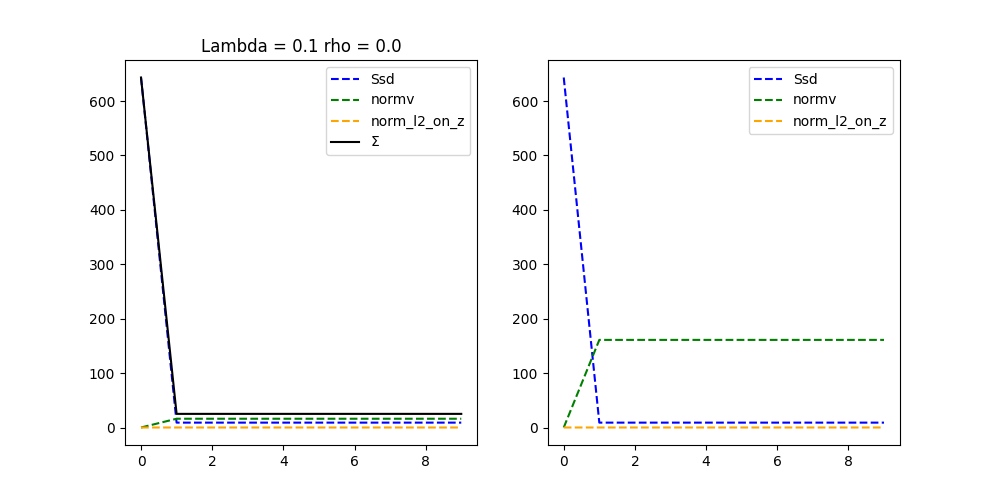

In [ ]:
kernelOperator = rk.GaussianRKHS(sigma=(5,5,5),normalized=False)
# datacost = mt.Rotation_Ssd_Cost(img_1.to('cuda:0'), alpha=.5)
# datacost = mt.Rotation_MutualInformation_Cost(target_b, alpha=.5)
datacost = None

momenta = mtrt.prepare_momenta(
    # mr.source.shape,
    img_1.shape,
    image=True,
    rotation=False,
    translation=False,
)

for v in momenta.values():
    print(v.requires_grad)

momentum_I = momenta["momentum_I"]

mr = mt.metamorphosis(
    img_1, img_2, momentum_ini=momentum_I,
    kernelOperator= kernelOperator,
    rho = 0,
    data_term=datacost ,
    integration_steps = 3,
    cost_cst=.1,
    n_iter=10,
    grad_coef=1,
    save_gpu_memory=True,
    lbfgs_max_iter = 20,
    lbfgs_history_size = 20,
)

mr.plot_cost()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05620303750038147..1.0].


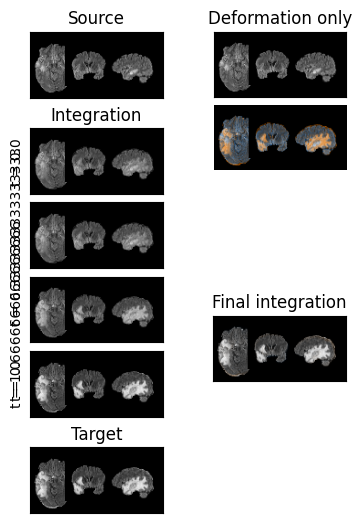

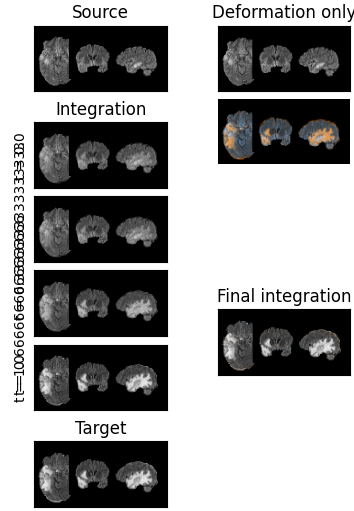

In [ ]:
my_slice = (55,96,75)
my_slice = tuple([s*scale_img for s in my_slice])
make_summary_fig(mr,my_slice)

In [ ]:
name_tosave = f"{name}_metamorphosis_rho{mr.mp.rho}"
mr.save(name_tosave)

/home/turtlefox/Documents/11_metamorphoses/Demeter_metamorphosis/src/demeter/metamorphosis/abstract.py:1572: RuntimeWarning: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
  ic(path)
ic| abstract.py:1572 in save()
    '/home/turtlefox/.local/share/Demeter_metamorphosis/saved_optim/'


Optimisation saved in /home/turtlefox/.local/share/Demeter_metamorphosis/saved_optim/3D_20250723_BraTSReg_021_metamorphosis_rho1_turtlefox_000.pk1 



('3D_20250723_BraTSReg_021_metamorphosis_rho1_turtlefox_000.pk1',
 '/home/turtlefox/.local/share/Demeter_metamorphosis/saved_optim/')

# RIGID


In [6]:
# torch.manual_seed(0)
# grid, affine = random_affine_def()

param = torch.tensor([
    0,0,torch.pi/4,
    0,0,0,
    1,1,1
])
affine = tb.create_affine_mat_3d(param)
grid = tb.affine_to_grid_3d(affine, img_1.shape[2:])
inv_aff = inverse_affine(affine)
inv_grid = tb.affine_to_grid_3d(inv_aff, img_1.shape[2:])

img_1_aff = tb.imgDeform(img_1, grid  )

inv_grid = tb.square2_to_pixel_convention(inv_grid,True)
land_1_aff = apply_aff_to_landmarks(land_1, inv_grid)


print("affine :", affine)
print("land_0_aff", land_1_aff)
# a3s.compare_images_with_landmarks(img_1, img_1_aff, land_1, land_1_aff, labels = ["origin", "displaced"])

print("Images ready to be registred")
print("^"*term_width)

source =  img_1_aff.contiguous()
target  = img_2.contiguous()

affine : tensor([[ 1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.7071, -0.7071,  0.0000],
        [-0.0000,  0.7071,  0.7071,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
land_0_aff tensor([[ 44.0000,  49.5381,  85.6005],
        [ 54.0000, 110.3492,  81.3579],
        [ 63.0000, 113.1777,  78.5294],
        [ 58.0000,  60.1447,  59.4376],
        [ 41.0000,  78.5294, 111.7635],
        [ 36.0000,  79.9436,  96.2071]])
Images ready to be registred
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


# Apply Metamorphosis  with rigid
## barycentre alignement

In [7]:
print("="*term_width)
print("Barycentre alignement\n")
shape_list = torch.tensor(source.size()[2:])/2
print(source.shape)
print(shape_list)

source_b, target_b, trans_s, trans_t = rg.align_barycentres(source, target, verbose=True)
land_1_b = land_1 - trans_s * shape_list
land_2_b = land_2 - trans_t * shape_list
print(land_1, land_1_b)
print(land_2, land_2_b)
# a3s.compare_images_with_landmarks(source, source_b,
#                                   land_1, land_1_b,
#                                   labels = ["source", "source_barycentred"])
# a3s.compare_images_with_landmarks(target, target_b,land_2, land_2_b,
#                                   labels = ["target", "target_barcentred"])
# a3s.compare_images_with_landmarks(source_b, target_b,
#                                   land_1_b, land_2_b,
#                                   labels = ["source_barycentred", 'target_barcentred'])

Barycentre alignement

torch.Size([1, 1, 192, 192, 124])
tensor([96., 96., 62.])
S compute barycentre : tensor([-0.0964,  0.0722, -0.0843])
T compute barycentre : tensor([-0.0790,  0.1302, -0.0551])
diff :  tensor([0.0174, 0.0579, 0.0293])
tensor([[ 44.8000,  70.4000,  56.0000],
        [ 54.4000, 116.8000,  96.0000],
        [ 63.2000, 120.8000,  96.0000],
        [ 58.4000,  96.8000,  45.6000],
        [ 41.6000,  72.0000,  95.2000],
        [ 36.8000,  84.8000,  85.6000]]) tensor([[ 54.0556,  63.4642,  61.2284],
        [ 63.6556, 109.8642, 101.2284],
        [ 72.4556, 113.8642, 101.2284],
        [ 67.6556,  89.8642,  50.8284],
        [ 50.8556,  65.0642, 100.4284],
        [ 46.0556,  77.8642,  90.8284]])
tensor([[ 47.2000,  70.4000,  55.2000],
        [ 54.4000, 116.8000,  97.6000],
        [ 60.8000, 123.2000,  96.0000],
        [ 59.2000,  96.0000,  45.6000],
        [ 41.6000,  72.0000,  96.0000],
        [ 39.2000,  84.8000,  85.6000]]) tensor([[ 54.7819,  57.9018,  58.6146

## Prepare Metamorphosis optimizer

In [23]:
kernelOperator = rk.GaussianRKHS(sigma=(15,15,15),normalized=False)
datacost = mt.Rotation_Ssd_Cost(target_b.to('cuda:0'), alpha=1)
# datacost = mt.Rotation_Cost(target_b, mt.Mutual_Information, alpha=1)

mr = mt.rigid_along_metamorphosis(
    source_b, target_b, momenta_ini=0,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
)

dict_keys(['source', 'target', 'geodesic', 'cost_cst', 'data_term', 'hamiltonian_integration', 'debug', 'lbfgs_max_iter', 'lbfgs_history_size'])


## Rigid Explorator

In [24]:

top_params = rg.initial_exploration(mr,r_step=5, max_output = 5, verbose=True)
print(top_params)

# top_params =  [
#     (torch.tensor(22700.7285), torch.tensor([-3.1416, -0.6283,  1.8850])),
#     (torch.tensor(22830.1152), torch.tensor([ 0.6283, -3.1416,  1.8850])),
# ]

Init search : 1 / 125
dict_keys(['momentum_R'])
	 (tensor(20950.4414), tensor([0., 0., 0.]))
Init search : 2 / 125
dict_keys(['momentum_R'])
	 (tensor(11918.5303), tensor([0.0000, 0.0000, 0.9425]))
Init search : 3 / 125
dict_keys(['momentum_R'])
	 (tensor(17882.3906), tensor([0.0000, 0.0000, 1.8850]))
Init search : 4 / 125
dict_keys(['momentum_R'])
	 (tensor(20327.1016), tensor([0.0000, 0.0000, 2.8274]))
Init search : 5 / 125
dict_keys(['momentum_R'])
	 (tensor(20978.0469), tensor([0.0000, 0.0000, 3.7699]))
Init search : 6 / 125
dict_keys(['momentum_R'])
	 (tensor(25164.4980), tensor([0.0000, 0.9425, 0.0000]))
Init search : 7 / 125
dict_keys(['momentum_R'])
	 (tensor(22366.1152), tensor([0.0000, 0.9425, 0.9425]))
Init search : 8 / 125
dict_keys(['momentum_R'])
	 (tensor(20806.6250), tensor([0.0000, 0.9425, 1.8850]))
Init search : 9 / 125
dict_keys(['momentum_R'])
	 (tensor(19837.4922), tensor([0.0000, 0.9425, 2.8274]))
Init search : 10 / 125
dict_keys(['momentum_R'])
	 (tensor(20100.10

## Optimize Rigid on best values


In [25]:
# torch.autograd.set_detect_anomaly(True)
best_loss, best_momentum, best_translation, best_rot = rg.optimize_on_rigid(mr, top_params, n_iter=10,verbose=True)

# rot_def =   tb.grid_from_rotation(mr.mp.id_grid, best_rot.T)
# rot_def -= best_translation
# img_rot = tb.imgDeform(mr.mp.image, rot_def.to('cpu'),
#                        dx_convention='2square', clamp=True)
#
# a3s.compare_images_with_landmarks(img_rot, source_b, land_1_b, land_2_b,
#                                   labels= ["img_rot", "source_b"],)
#
# a3s.compare_images_with_landmarks(img_rot, target_b, land_1_b, land_2_b,
#                                   labels= ["img_rot", "target_b"],)

best_momentum_R = torch. tensor([[ 0.0000, -0.0346,  0.0130],
        [ 0.0346,  0.0000, -0.8884],
        [-0.0130,  0.8884,  0.0000]])
best_momentum_T = torch. tensor([-0.0092, -0.0018,  0.0441])
# best_rotation = tensor([[ 0.0655,  0.8918,  0.4477],
#         [-0.9973,  0.0430,  0.0602],
#         [ 0.0344, -0.4504,  0.8921]])

>>>>>>>>>>
0/5 Optimize wit params [0.0, 0.0, 0.942477822303772]
momenta type <class 'dict'>
Progress: [##--------]  20.00%  (Rotation_Ssd_Cost : ,7750.8848).
Progress: [###-------]  30.00%  (Rotation_Ssd_Cost : ,7750.8809).
Progress: [####------]  40.00%  (Rotation_Ssd_Cost : ,7750.8809).
Progress: [#####-----]  50.00%  (Rotation_Ssd_Cost : ,7750.8809).
Progress: [######----]  60.00%  (Rotation_Ssd_Cost : ,7750.8809).
Progress: [#######---]  70.00%  (Rotation_Ssd_Cost : ,7750.8809).
Progress: [########--]  80.00%  (Rotation_Ssd_Cost : ,7750.8809).
Progress: [#########-]  90.00%  (Rotation_Ssd_Cost : ,7750.8809).
Progress: [##########] 100.00% Done...
 (Rotation_Ssd_Cost : ,7750.8809).

Computation of forward done in  0:00:05s and 0.030cents  s
best = True
tensor([-0.0092, -0.0018,  0.0441])
tensor([[ 0.9995, -0.0235,  0.0223],
        [ 0.0324,  0.6954, -0.7179],
        [ 0.0014,  0.7183,  0.6958]])
<<<<<<<<<<
>>>>>>>>>>
1/5 Optimize wit params [0.0, 0.0, 1.884955644607544]
momenta t

tensor([[ 0.0000, -0.0346,  0.0130],
        [ 0.0346,  0.0000, -0.8884],
        [-0.0130,  0.8884,  0.0000]], requires_grad=True)
tensor([-0.0092, -0.0018,  0.0441], requires_grad=True)
dict_keys(['source', 'target', 'geodesic', 'cost_cst', 'data_term', 'hamiltonian_integration', 'debug', 'lbfgs_max_iter', 'lbfgs_history_size'])
tensor([[ 0.9995, -0.0235,  0.0223],
        [ 0.0324,  0.6954, -0.7179],
        [ 0.0014,  0.7183,  0.6958]], grad_fn=<MmBackward0>)


Text(0.5, 1.0, 'img vs source')

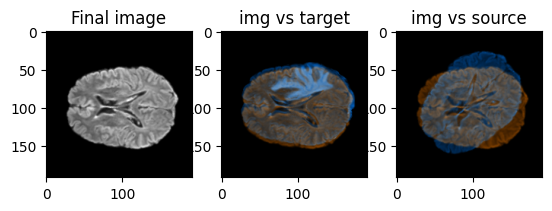

In [26]:

momenta = mtrt.prepare_momenta(
    # mr.source.shape,
    img_1.shape,
    image=False,
    rotation=True,
    translation=True,
    rot_prior=best_momentum_R.detach().clone(),trans_prior=best_momentum_T.detach().clone(),
    device= "cpu"
)
print(momenta["momentum_R"])
print(momenta["momentum_T"])
kernelOperator = rk.GaussianRKHS(sigma=(10,10,10),normalized=False)
datacost = mt.Rotation_Ssd_Cost(img_1.to('cuda:0'), alpha=.5)
# datacost = mt.Rotation_Cost(target_b, mt.Mutual_Information, alpha=.5)
mr = mt.rigid_along_metamorphosis(
    source, target, momenta_ini=momenta,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
    n_iter=0,
    save_gpu_memory=False,
    lbfgs_max_iter = 20,
    lbfgs_history_size = 20,
)
mr.mp.forward(source.cpu(), momenta, save=True)

print(mr.mp.rot_mat)

# rot_def = tb.grid_from_rotation_translation(mr.mp.id_grid, mr.mp.rot_mat, mr.mp.translation)
# rot_def =   tb.grid_from_rotation(mr.mp.id_grid, mr.mp.rot_mat.T)
# rot_def += mr.mp.translation
rot_def = mr.mp.get_rotator_translator()
rotated_source = tb.imgDeform(mr.mp.image,rot_def,dx_convention='2square')
img = rotated_source[0,0,..., mr.source.shape[-1]//2].detach().cpu()
img_target = tb.imCmp(rotated_source[..., source.shape[-1]//2].detach().cpu(), mr.target[..., source.shape[-1]//2].detach().cpu(), "compose")[0]
img_source = tb.imCmp(rotated_source[..., source.shape[-1]//2].detach().cpu(), mr.source[..., source.shape[-1]//2].detach().cpu(), "compose")[0]
fig,ax = plt.subplots(1,3)
ax[0].imshow(img, cmap="gray")
ax[0].set_title("Final image")
ax[1].imshow(img_target, cmap="gray")
ax[1].set_title("img vs target")
ax[2].imshow(img_source, cmap="gray")
ax[2].set_title("img vs source")

## Metamorphosis along rigid

Text(0.5, 1.0, 'target')

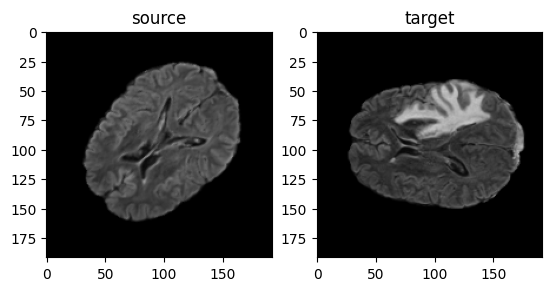

In [8]:
fig, ax = plt.subplots(1,2)
T, _, D, H, W = source.shape

max_st = max(source.max(), target.max())
min_st = min(source.min(), target.min())
# Choose a central slice for plotting
slice_index = W // 2
ax[0].imshow(source[0,0,..., slice_index], cmap='gray', clim=(min_st,max_st))
ax[0].set_title(f'source')

ax[1].imshow(target[0,0,..., slice_index], cmap='gray', clim=(min_st,max_st))
ax[1].set_title(f'target')

In [39]:
# prompt: empty GPU memory
del mr
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

93504

In [21]:
best_momentum_R = torch. tensor([[ 0.0000, -0.0346,  0.0130],
        [ 0.0346,  0.0000, -0.8884],
        [-0.0130,  0.8884,  0.0000]])
best_momentum_T = torch. tensor([-0.0092, -0.0018,  0.0441])
kernelOperator = rk.GaussianRKHS(sigma=(10,10,10),normalized=False)
# sigma = (.05,.05, .05)
# dx = tuple( [1/s for s in source.shape[2:]] )
# print(dx)
# kernelOperator = rk.VolNormalizedGaussianRKHS(sigma=sigma,
#                                               sigma_convention="continuous",
#                                               dx = dx,
#                                               )
# print(kernelOperator)
datacost = mt.Rotation_Ssd_Cost(target_b.to("cuda:0"), alpha=.5)
# datacost = mt.Rotation_MutualInformation_Cost(target_b, alpha=.5)

momenta = mtrt.prepare_momenta(
    # mr.source.shape,
    img_1.shape,
    image=True,
    rotation=True,
    translation=True,
    rot_prior=best_momentum_R.detach().clone(),trans_prior=best_momentum_T.detach().clone(),
)

for v in momenta.values():
    print(v.requires_grad)
rho = .1
mr = mt.rigid_along_metamorphosis(
    source, target, momenta_ini=momenta,
    kernelOperator= kernelOperator,
    rho = rho,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=1e-6,
    n_iter=5,
    save_gpu_memory=False,
    lbfgs_max_iter = 20,
    lbfgs_history_size = 20,
)

# mr = mt.metamorphosis(
#     img_1, img_2, momentum_ini=momenta,
#     kernelOperator= kernelOperator,
#     rho = 1,
#     data_term=datacost ,
#     integration_steps = 10,
#     cost_cst=.1,
#     n_iter=10,
#     grad_coef=1
# )

mr.plot_cost()
mr.compute_landmark_dist(land_1,  land_2)

# a3s.compare_images_with_landmarks(mr.mp.image, img_1,
#                                   labels= ["Final", "source"],)
# a3s.compare_images_with_landmarks(mr.mp.image, img_2,
#                                   labels= ["Final", "target_b"],)

True
True
True
dict_keys(['source', 'target', 'geodesic', 'cost_cst', 'data_term', 'hamiltonian_integration', 'debug', 'lbfgs_max_iter', 'lbfgs_history_size'])
momenta type <class 'dict'>


OutOfMemoryError: CUDA out of memory. Tried to allocate 136.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 102.88 MiB is free. Process 145350 has 39.45 GiB memory in use. Of the allocated memory 35.27 GiB is allocated by PyTorch, and 3.67 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

residual min -0.006734699010848999 max 0.024286683648824692


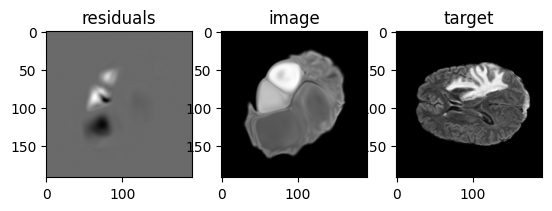

In [20]:
fig, ax = plt.subplots(1,3)
T, _, D, H, W = source.shape
print(f"residual min {mr.mp.residuals.min()} max {mr.mp.residuals.max()}")
# Choose a central slice for plotting
slice_index = W // 2
ax[0].imshow(mr.mp.residuals[0,0,..., slice_index].cpu(), cmap='gray')
ax[0].set_title(f'residuals')
ax[1].imshow(mr.mp.image[0,0,..., slice_index].cpu(), cmap='gray')
ax[1].set_title(f'image')

ax[2].imshow(target[0,0,..., slice_index], cmap='gray')
ax[2].set_title(f'target')
plt.show()

rot_def device: cpu
comparison_img shape torch.Size([192, 192])
comparison_img shape torch.Size([192, 192])
comparison_img shape torch.Size([192, 192])
comparison_img shape torch.Size([192, 192])
comparison_img shape torch.Size([192, 192])
comparison_img shape torch.Size([192, 192])
comparison_img shape torch.Size([192, 192])
comparison_img shape torch.Size([192, 192])
comparison_img shape torch.Size([192, 192])
comparison_img shape torch.Size([192, 192])


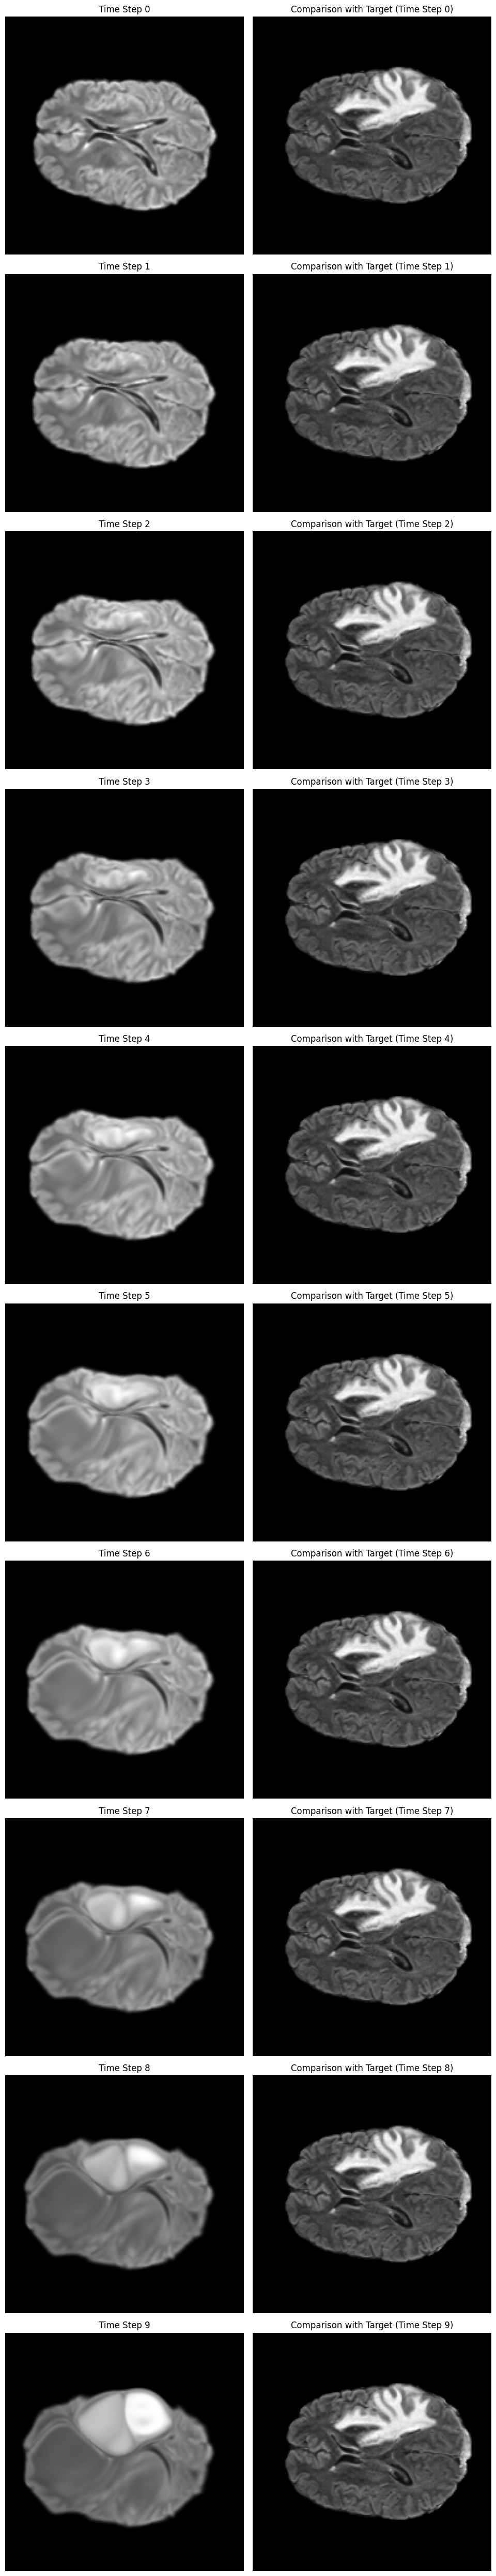

In [13]:
mr.to_device("cpu")
# Assuming 'mr' is the metamorphosis object created in the preceding code
plot_metamorphosis_slices(mr)


In [ ]:
mr.save(f"{name}_rigid_metamorphosis_colab",save_path="/content/drive/MyDrive/demeter_data/demeter_optim/")

ic| abstract.py:1572 in save()
    path: '/content/drive/MyDrive/demeter_data/demeter_optim/'



BUG WARNING : An other data term than Ssd was detectedFor now our method can't save it, it is ok to visualisethe optimisation, but be careful loading the optimisation.

Optimisation saved in /content/drive/MyDrive/demeter_data/demeter_optim/3D_20250725_BraTSReg_021_rigid_metamorphosis_colab_root_000.pk1 



('3D_20250725_BraTSReg_021_rigid_metamorphosis_colab_root_000.pk1',
 '/content/drive/MyDrive/demeter_data/demeter_optim/')